<a href="https://colab.research.google.com/github/surpha/mVQA/blob/main/divide/VQA/Feature%20Extraction/Image_Feature_Extraction_CLIP_and_VizWiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.kaggle.com/datasets/lhanhsin/vizwiz
#THis is the Dataset I am using

# https://github.com/surpha/mVQA/blob/main/Research%20Paper%20References/feature%20extraction/Less%20Is%20More%20-%20Linear%20Layers%20on%20CLIP%20Features%20as%20Powerful%20VizWiz%20Model.pdf
# THis is the architecture I am following

Each Linear layer consist of Layer Norm followed by Drop out with probability of 0.5 followed by fully connected layer of size 512.
We will have Cross Entropy Loss for answer and answer type
We will use Binary Cross Entropy Loss for answerability


)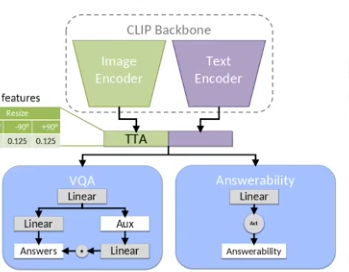

In [1]:
!git clone https://github.com/yousefkotp/Visual-Question-Answering.git

Cloning into 'Visual-Question-Answering'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 296 (delta 26), reused 35 (delta 12), pack-reused 238
Receiving objects: 100% (296/296), 16.23 MiB | 30.65 MiB/s, done.
Resolving deltas: 100% (139/139), done.


In [3]:
%cd /content/Visual-Question-Answering

/content/Visual-Question-Answering


In [4]:
!pip install -r requirements.txt

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yg09k7wt
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-yg09k7wt
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 854.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━

Start execution from here


In [16]:
!pip install ftfy regex tqdm
!pip install pandas
!pip install wordcloud
!pip install scikit-learn
!pip install Levenshtein
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_rzz61bd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_rzz61bd
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


Importing libraries in Header

In [17]:
# Importing os, numpy and pandas for data manipulation
import os
import numpy as np
import pandas as pd

# For data visualization, we will use matplotlib, wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For data preprocessing, we will use Counter, train_test_split, Levenshtein distance, Python Image Library and OneHotEncoder
from collections import Counter
import Levenshtein as lev
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# For saving and loading the preprocessed data, we will use pickle
import pickle

# For Building the model, we will use PyTorch and its functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import clip
from torch.utils.data import Dataset, DataLoader

# For taking the image from the URL, we will use requests
import requests

# For evaluation, we will need sklearn.metrics.average_precision_score
from sklearn.metrics import average_precision_score

# Importing json for results formatting which will be uploaded for evaluation
import json

In [18]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
# download annotations file from https://vizwiz.org/tasks-and-datasets/vqa/
# Upload ZIP to Colab by executing the code below

In [8]:
import zipfile
import os

# Define the path to the zip file
zip_file_path = '/content/Annotations.zip'

# Define the directory where you want to extract the contents
extract_dir = '/content/Annotations'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Annotations have been successfully unzipped.")

Annotations have been successfully unzipped.


Setting up Paths

In [9]:
# Configuring the paths for the dataset
INPUT_PATH = '/content'
ANNOTATIONS = INPUT_PATH + '/Annotations'
TRAIN_PATH = INPUT_PATH + '/train/train'
VALIDATION_PATH = INPUT_PATH + '/val/val'
ANNOTATIONS_TRAIN_PATH = ANNOTATIONS + '/train.json'
ANNOTATIONS_VAL_PATH = ANNOTATIONS + '/val.json'
OUTPUT_PATH = '/content'
ANSWER_SPACE = 0 # Will be configured later when we build the vocab using the methodology described in the paper
MODEL_NAME = "ViT-L/14@336px" # This is the backbone of the CLIP model

Processing Data

**read_dataframe function** reads a JSON file and returns a dataframe with required columns

**split_train_test function** splits the dataframe into train and test sets

**plot_histogram, plot_pie, and plot_wordcloud functions** plot the histogram, pie chart, and wordcloud of the given column, respectively

**explore_dataframe function** explores the dataframe by utilizing the previous functions

**get_number_of_distinct_answers function** returns the number of distinct answers in the dataframe

**process_images function** processes the images in the dataframe and returns the image features using Open AI's CLIP model

**process_questions function** processes the questions in the dataframe and returns the question features using Open AI's CLIP model

In [6]:
def read_dataframe(path):
    """
    Reads the JSON file and returns a dataframe with the required columns (image, question, answers, answer_type, answerable)

    Parameters:
        path (str): Path to the JSON file

    Returns:
        df (pandas.DataFrame): Dataframe with the required columns
    """
    df = pd.read_json(path)
    df = df[['image', 'question', 'answers', 'answer_type', 'answerable']]
    return df

def split_train_test(dataframe, test_size = 0.05):
    """
    Splits the dataframe into train and test sets

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be split

    Returns:
        train (pandas.DataFrame): Train set
        test (pandas.DataFrame): Test set
    """
    train, test = train_test_split(dataframe, test_size=test_size, random_state=42, stratify=dataframe[['answer_type', 'answerable']])
    return train, test

def plot_histogram(dataframe, column):
    """
    Plots the histogram of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    plt.hist(dataframe[column])
    plt.title(column)
    plt.show()

def plot_pie(dataframe, column):
    """
    Plots the pie chart of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    value_counts = dataframe[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(column)
    plt.show()

def plot_wordcloud(dataframe, column):
    """
    Plots the wordcloud of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    text = " ".join([word for word in dataframe[column]])

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

def explore_dataframe(dataframe):
    """
    Explores the dataframe (EDA) by plotting the pie charts, histograms and wordclouds of the columns

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        None
    """
    plot_pie(dataframe, 'answer_type')
    plot_pie(dataframe, 'answerable')
    plot_histogram(dataframe, 'answerable')
    plot_wordcloud(dataframe, 'question')

def get_number_of_distinct_answers(dataframe):
    """
    Returns the number of distinct answers in the dataframe

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        len(unique_answers_set) (int): Number of distinct answers in the dataframe
    """
    unique_answers_set = set()
    for row in dataframe['answers']:
        for answer_map in row:
            unique_answers_set.add(answer_map['answer'])
    return len(unique_answers_set)

def process_images(dataframe, image_path, clip_model, preprocessor, device):
    """
    Processes the images in the dataframe and returns the image features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the images
        image_path (str): Path to the input images
        clip_model (clip.model.CLIP): CLIP model
        preprocessor (clip.model.Preprocess): Preprocessor for the CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        images (list): List of image features
    """
    images = []
    for _, row in dataframe.iterrows():
        full_path = image_path + "/" + row['image']
        image = Image.open(full_path)
        image = preprocessor(image).unsqueeze(0).to(device)
        image_features = clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)
        images.append(image_features)
    return images

def process_questions(dataframe, clip_model,device):
    """
    Processes the questions in the dataframe and returns the question features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the questions
        clip_model (clip.model.CLIP): CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        questions (list): List of question features
    """
    questions = []
    for _, row in dataframe.iterrows():
        question = row['question']
        question =  clip.tokenize(question).to(device)
        text_features = clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)
        questions.append(text_features)
    return questions

In [10]:
train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH)
validation_df = read_dataframe(ANNOTATIONS_VAL_PATH)
train_df, test_df = split_train_test(train_df, test_size=0.05)
ANSWER_SPACE = get_number_of_distinct_answers(train_df) # The answer space will be decreased later when we process the answers
print("Number of distinct answers: ", ANSWER_SPACE)

Number of distinct answers:  39512


Exploratory Data Analysis

Training Data

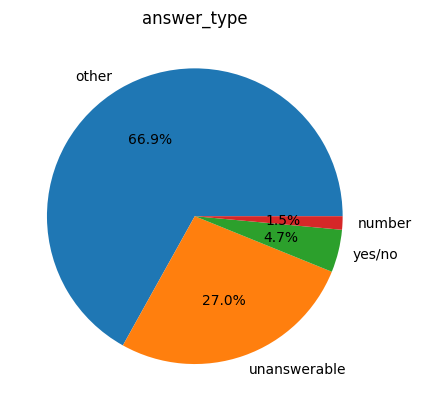

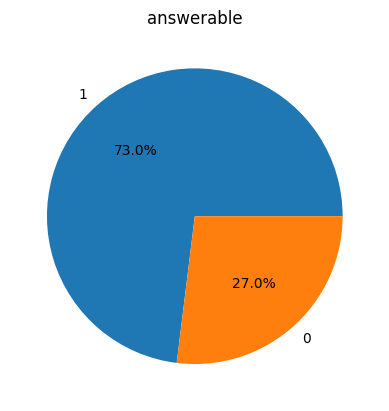

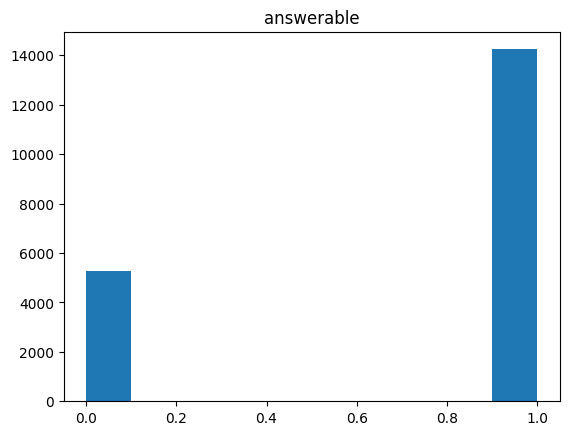

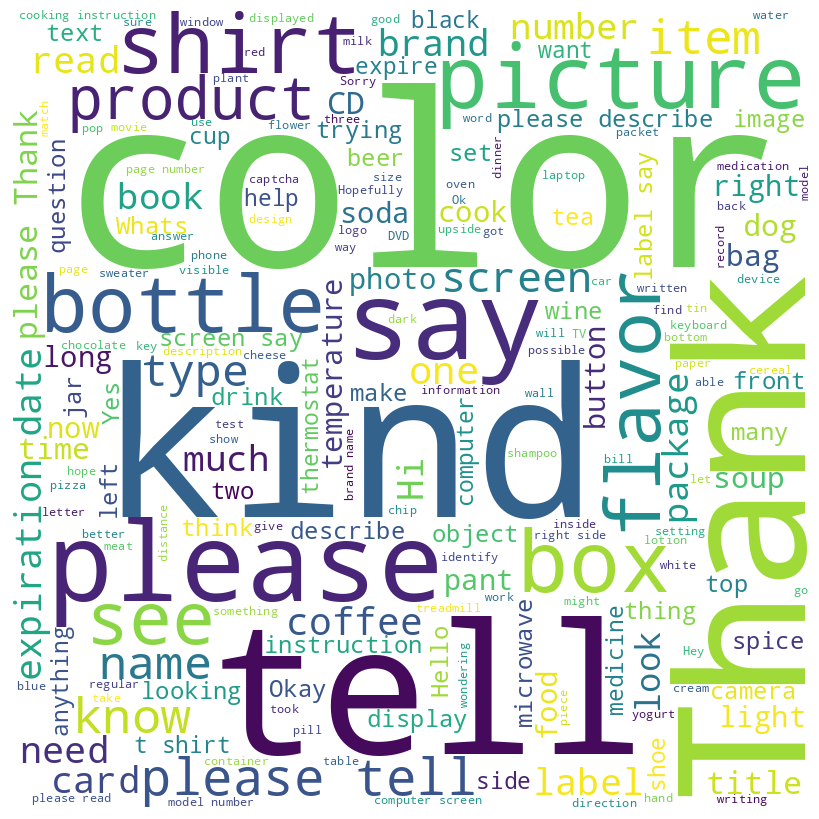

Number of distinct answers:  39512
Number of samples in train:  19496


In [11]:
explore_dataframe(train_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(train_df))
print("Number of samples in train: ", len(train_df))

Validation Data

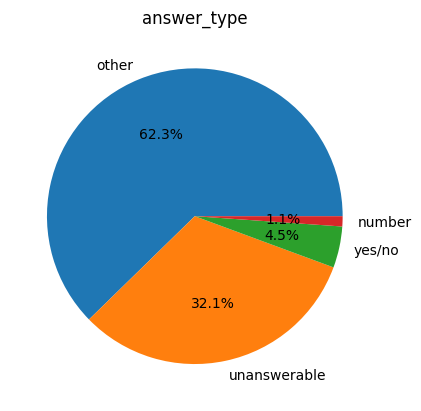

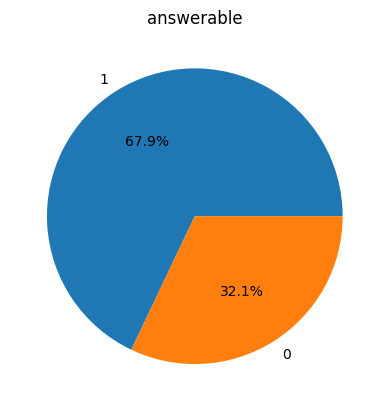

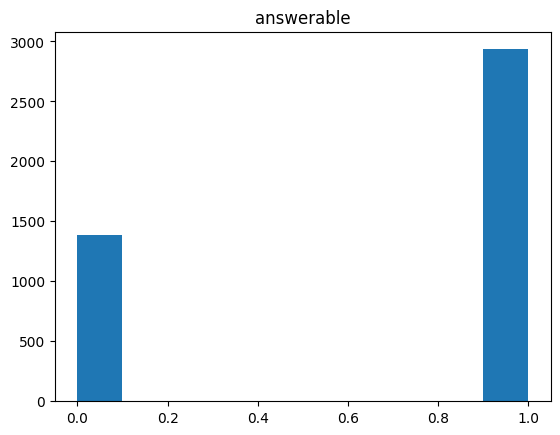

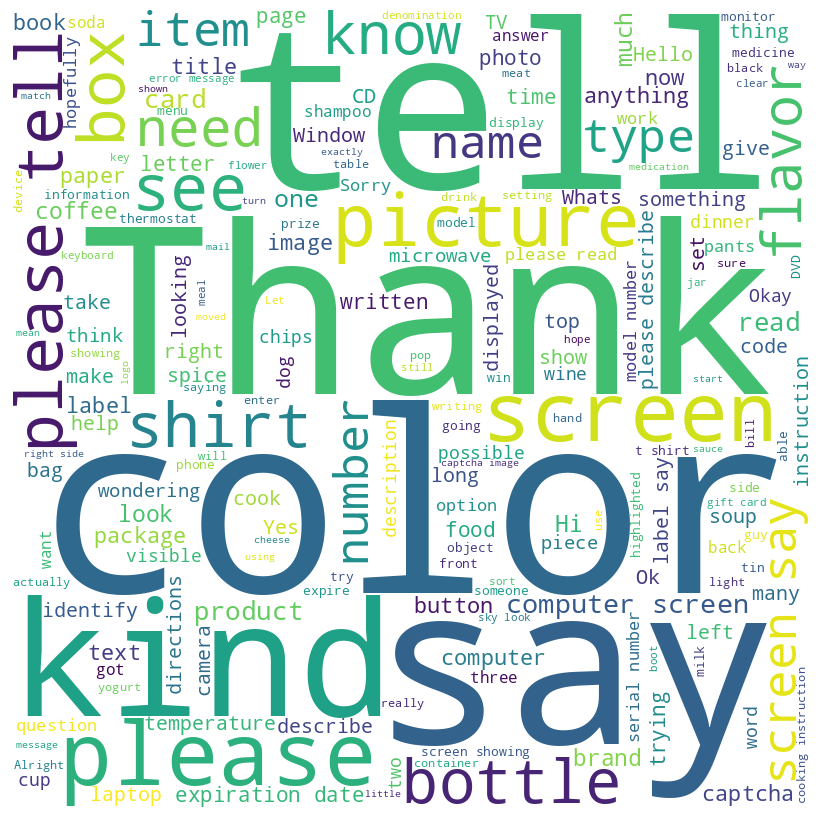

Number of distinct answers:  10903
Number of samples in validation set:  4319


In [13]:
explore_dataframe(validation_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(validation_df))
print("Number of samples in validation set: ", len(validation_df))

Testing Dataframe

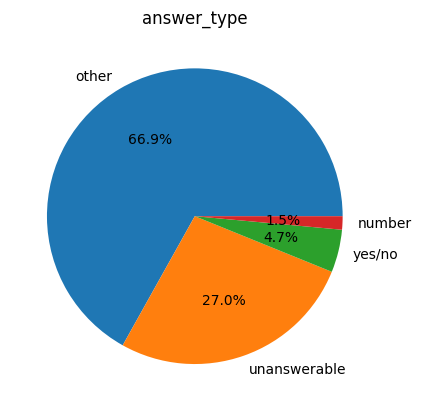

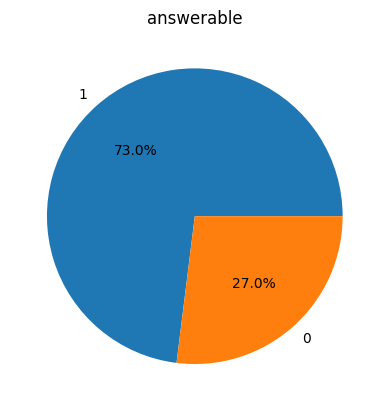

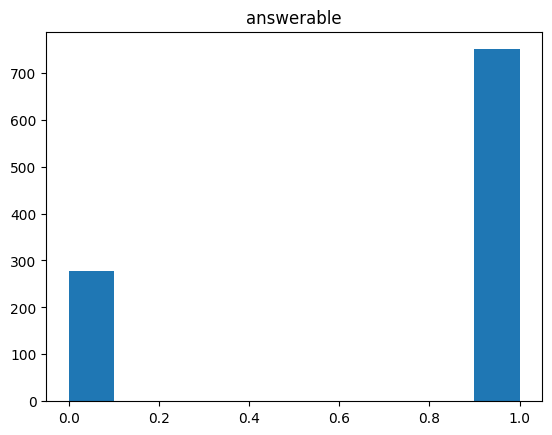

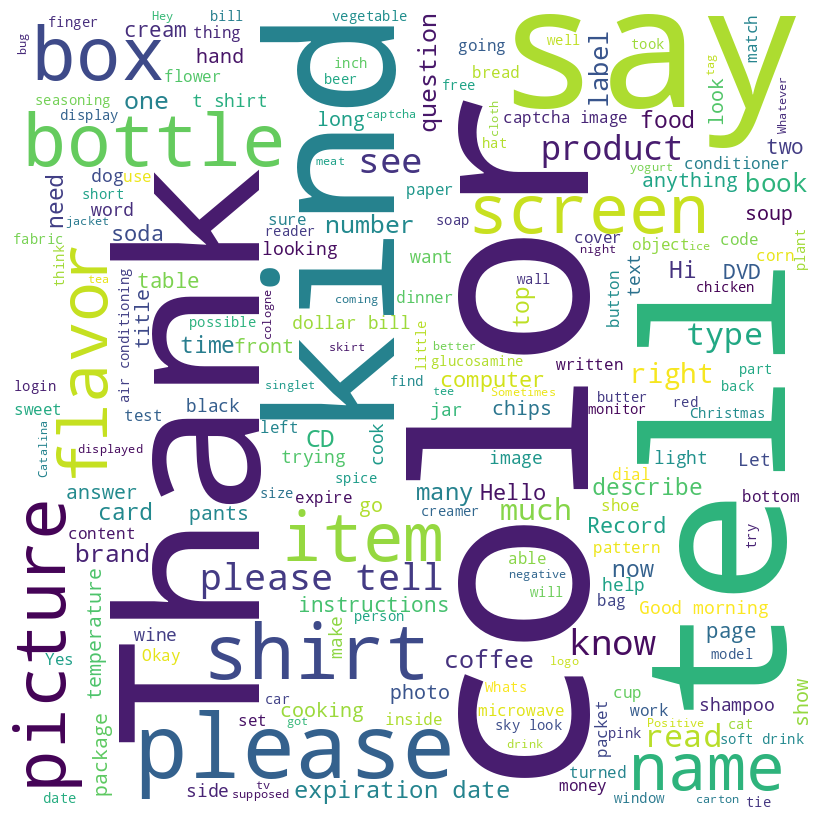

Number of distinct answers:  3005
Number of samples in test:  1027


In [14]:
explore_dataframe(test_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(test_df))
print("Number of samples in test: ", len(test_df))

# Processing Images & Questions using CLIP model

Instead of lazy processing of images and questions embeddings and recomputing them over and over during forward passes in the model, we can preprocess them and save them in a file using Pickle. This will save us a lot of time when we want to train our model and decrease the time taken by one epoch drastically

In [15]:
clip_model, preprocessor = clip.load(MODEL_NAME, device = DEVICE)
clip_model.eval().requires_grad_(False)

training_images = process_images(train_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
training_questions = process_questions(train_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'training_images.pkl', 'wb') as f:
    pickle.dump(training_images, f)
with open(OUTPUT_PATH + 'training_questions.pkl', 'wb') as f:
    pickle.dump(training_questions, f)

validation_images = process_images(validation_df, VALIDATION_PATH, clip_model, preprocessor, DEVICE)
validation_questions = process_questions(validation_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'validation_images.pkl', 'wb') as f:
    pickle.dump(validation_images, f)
with open(OUTPUT_PATH + 'validation_questions.pkl', 'wb') as f:
    pickle.dump(validation_questions, f)

test_images = process_images(test_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
test_questions = process_questions(test_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'test_images.pkl', 'wb') as f:
    pickle.dump(test_images, f)
with open(OUTPUT_PATH + 'test_questions.pkl', 'wb') as f:
    pickle.dump(test_questions, f)

100%|███████████████████████████████████████| 891M/891M [06:15<00:00, 2.48MiB/s]


FileNotFoundError: [Errno 2] No such file or directory: '/content/train/train/VizWiz_train_00014709.jpg'